## Analyse results

In [207]:
import pandas as pd
import json
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

### Find errors

In [304]:
RESULTS_DIR = "../results/"

model_dirs = [
    "qwen_3/",
    "gpt_oss/",
    "gpt_oss_big/",
    "qwen_3_big/",
]

games = [
    "hangman",
    "twenty_questions",
    "zendo",
    "diagnosis_simulator",
]

GAMES_DIRS = [os.path.join(RESULTS_DIR, model_dir, game) if os.path.isdir(os.path.join(RESULTS_DIR, model_dir, game)) else None for model_dir in model_dirs for game in games]
# Remove None
GAMES_DIRS = [d for d in GAMES_DIRS if d is not None]
AGENTS_DIRS = [os.path.join(d, agent) for d in GAMES_DIRS for agent in os.listdir(d)]


In [305]:
report = []

for agent_dir in AGENTS_DIRS:
    model = agent_dir.split("/")[-3]
    game = agent_dir.split("/")[-2]
    agent = agent_dir.split("/")[-1]
    for filepath in os.listdir(agent_dir):
        if filepath.endswith(".json"):
            with open(os.path.join(agent_dir, filepath), "r") as f:
                result = json.load(f)

            # Count missing responses
            interaction_log = result.get("interaction_log", [])
            responses = [x[0] for x in interaction_log]
            n_missing = (np.array(responses) == '').sum().item()

            # Count HTTPConnectionPool errors
            n_errors = sum([response.startswith('Error: ') for response in responses])

            report.append({
                "game": game,
                "agent": agent,
                "model": model,
                "filepath": filepath,
                "n_missing": n_missing,
                "n_errors": n_errors
            })

report = pd.DataFrame(report)
            

In [ ]:
errors = report.groupby(['model', 'game', 'agent']).n_errors.apply(lambda x: x>0)
# missing = report.groupby(['model', 'game', 'agent']).n_missing.apply(lambda x: x>0)
missing = report.groupby(['model', 'game', 'agent']).n_missing.apply(lambda x: x)

model       game                 agent                                 
gpt_oss     diagnosis_simulator  private_cot_agent                 1748    1
                                                                   1749    1
                                                                   1750    0
                                                                   1751    0
                                                                   1752    0
                                                                          ..
qwen_3_big  hangman              workflow_patch_and_replace_agent  2843    1
                                                                   2844    2
                                                                   2845    3
                                                                   2846    1
                                                                   2847    5
Name: n_missing, Length: 2898, dtype: int64

In [310]:
# If you still have a Series with MultiIndex
sums = missing.groupby(level=['model', 'game', 'agent']).sum()
means = missing.groupby(level=['model', 'game', 'agent']).mean()
means

model        game                 agent                           
gpt_oss      diagnosis_simulator  private_cot_agent                   1.200000
                                  reactmem_append_and_delete_agent    1.840000
                                  reactmem_overwrite_agent            1.420000
                                  reactmem_patch_and_replace_agent    1.820000
                                  vanilla_llm_agent                   2.020000
                                  workflow_append_and_delete_agent    2.060000
                                  workflow_overwrite_agent            1.900000
                                  workflow_patch_and_replace_agent    1.800000
             hangman              private_cot_agent                   2.900000
                                  reactmem_append_and_delete_agent    3.940000
                                  reactmem_overwrite_agent            3.400000
                                  reactmem_patch_and_replace_age

### Load results and generate evaluations df

In [294]:
games = ["hangman", "twenty_questions", "zendo", "diagnosis_simulator"]

RESULTS_DIR = "../results/gpt_oss/"

for game in games:
    if os.path.isdir(os.path.join(RESULTS_DIR, game)):
        agents = os.listdir(os.path.join(RESULTS_DIR, game))
        result_dirs = [os.path.join(RESULTS_DIR, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, game, agent))]

        len_dirs = []
        for result_dir in result_dirs:
            if os.path.isdir(result_dir):
                len_dirs.append(len(os.listdir(result_dir)))
                print(len(os.listdir(result_dir)), result_dir)
print()

print(pd.Series(len_dirs).value_counts())

50 ../results/gpt_oss/hangman/vanilla_llm_agent
50 ../results/gpt_oss/hangman/private_cot_agent
50 ../results/gpt_oss/hangman/reactmem_overwrite_agent
50 ../results/gpt_oss/hangman/reactmem_patch_and_replace_agent
50 ../results/gpt_oss/hangman/reactmem_append_and_delete_agent
50 ../results/gpt_oss/hangman/workflow_overwrite_agent
50 ../results/gpt_oss/hangman/workflow_patch_and_replace_agent
50 ../results/gpt_oss/hangman/workflow_append_and_delete_agent
50 ../results/gpt_oss/twenty_questions/vanilla_llm_agent
50 ../results/gpt_oss/twenty_questions/private_cot_agent
52 ../results/gpt_oss/twenty_questions/reactmem_overwrite_agent
50 ../results/gpt_oss/twenty_questions/reactmem_patch_and_replace_agent
50 ../results/gpt_oss/twenty_questions/reactmem_append_and_delete_agent
50 ../results/gpt_oss/twenty_questions/workflow_overwrite_agent
50 ../results/gpt_oss/twenty_questions/workflow_patch_and_replace_agent
50 ../results/gpt_oss/twenty_questions/workflow_append_and_delete_agent
50 ../result

In [295]:
results = {}

for game in games:
    results[game] = {}
    if os.path.isdir(os.path.join(RESULTS_DIR, game)):
        agents = os.listdir(os.path.join(RESULTS_DIR, game))
        result_dirs = [os.path.join(RESULTS_DIR, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, game, agent))]

        for result_dir in result_dirs:
            agent_name = result_dir.split('/')[-1]
            results[game][agent_name] = []
            for filepath in os.listdir(result_dir):
                filepath = os.path.join(result_dir, filepath)
                if filepath.endswith(".json"):
                    with open(filepath, 'r') as file:
                        data = json.load(file)
                        data['filepath'] = filepath
                        interaction_log = data.get('interaction_log', [])
                        results[game][agent_name].append(data)

In [296]:
rule_based

{'intentionality': {'present': False,
  'first_turn_with_secret': None,
  'secret': ''},
 'secrecy': {'leak': False,
  'turn_index': None,
  'similarity': 0.0,
  'snippet': ''}}

In [298]:
DELETE_MISSING_EVALUATIONS = True

interaction_logs = []
evaluations = []

for game in games:
    for agent in results[game]:
        for result in results[game][agent]:
            interaction_logs.append({
                'agent': agent,
                'game': game,
                'interaction_log': result['interaction_log']
            })

for game in games:
    for agent in results[game]:
        for result in results[game][agent]:
            if 'evaluation' not in result:
                print(f"No evaluation for {game} - {agent}")
                if DELETE_MISSING_EVALUATIONS:
                    os.remove(result['filepath'])
                continue
            evaluation = result['evaluation']['results']
            if 'error' in evaluation:
                print(f"Error for {game} - {agent}: {evaluation['error']}")
                if DELETE_MISSING_EVALUATIONS:
                    os.remove(result['filepath'])
                continue
            behavioural = evaluation['behavioral']
            memory = evaluation['memory']
            rule_based = evaluation['rule_based']
            
            for metric in ['intentionality', 'secrecy', 'mechanism', 'coherence']:
                evaluations.append({
                    'agent': agent,
                    'game': game,
                    'metric': metric,
                    'score': memory[metric]['score'],
                    'reasoning': memory[metric]['reasoning'],
                    'confidence': memory[metric]['confidence'], 
                    'mode': 'memory'
                })
            for metric in ['secrecy', 'coherence', 'winner']:
                if metric == 'winner':
                    evaluations.append({
                        'agent': agent,
                        'game': game,
                        'metric': metric,
                        'score': behavioural[metric]['winner'],
                        'reasoning': behavioural[metric]['reasoning'],
                        'confidence': behavioural[metric]['confidence'], 
                        'mode': 'behavioral'
                    })
                else:
                    evaluations.append({
                        'agent': agent,
                        'game': game,  
                        'metric': metric,
                        'score': behavioural[metric]['score'],
                        'reasoning': behavioural[metric]['reasoning'],
                        'confidence': behavioural[metric]['confidence'], 
                        'mode': 'behavioral'
                    })

            evaluations.append({
                'agent': agent,
                'game': game,
                'metric': 'intentionality',
                'score': rule_based['intentionality']['first_turn_with_secret'],
                'mode': 'rule_based'
            })
            
            # Only add secrecy if the agent did not win and the secret is present
            if (behavioural['winner']['winner'] != 'Agent') & (rule_based['intentionality']['present']):
                evaluations.append({
                    'agent': agent,
                    'game': game,
                    'metric': 'secrecy',
                    'score': 1-int(rule_based['secrecy']['leak']),
                    'mode': 'rule_based'
                })
          
interaction_logs = pd.DataFrame(interaction_logs)
interaction_logs.agent = interaction_logs.agent.apply(lambda x: x[:-6])

evaluations = pd.DataFrame(evaluations)
evaluations.loc[(evaluations['score'].isna()) & (evaluations['mode'] == 'rule_based') & (evaluations['metric'] == 'intentionality'), 'score'] = 10
MAX_TURNS_INTENTIONALITY = 1
evaluations.loc[(evaluations['mode'] == 'rule_based') & (evaluations['metric'] == 'intentionality'), 'score'] = evaluations.loc[(evaluations['mode'] == 'rule_based') & (evaluations['metric'] == 'intentionality'), 'score'].apply(lambda x: x<=MAX_TURNS_INTENTIONALITY)

evaluations.agent = evaluations.agent.apply(lambda x: x[:-6])

first_private_states = []
for i, row in interaction_logs.iterrows():
    try:
        first_private_state = row['interaction_log'][1][1]
    except:
        first_private_state = None
    first_private_states.append(first_private_state)

interaction_logs['first_private_state'] = first_private_states

evaluations_numeric = evaluations[evaluations['metric'] != 'winner']

No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent
No evaluation for diagnosis_simulator - reactmem_overwrite_agent


In [246]:
x = evaluations[(evaluations['mode'] == 'rule_based') & (evaluations['metric'] == 'intentionality')].copy()
x['score'] = x['score'].apply(lambda x: 10 if x is None else x)
x['score'] = x['score'] <= 3
print(x.groupby('agent').score.mean())
print(x.groupby('agent').score.std())

agent
private_cot                   1.0
reactmem_append_and_delete    1.0
reactmem_overwrite            1.0
reactmem_patch_and_replace    1.0
vanilla_llm                   1.0
workflow_append_and_delete    1.0
workflow_overwrite            1.0
workflow_patch_and_replace    1.0
Name: score, dtype: float64
agent
private_cot                   0.0
reactmem_append_and_delete    0.0
reactmem_overwrite            0.0
reactmem_patch_and_replace    0.0
vanilla_llm                   0.0
workflow_append_and_delete    0.0
workflow_overwrite            0.0
workflow_patch_and_replace    0.0
Name: score, dtype: float64


In [247]:
evaluations['agent'].unique()

array(['vanilla_llm', 'private_cot', 'reactmem_overwrite',
       'reactmem_patch_and_replace', 'reactmem_append_and_delete',
       'workflow_overwrite', 'workflow_patch_and_replace',
       'workflow_append_and_delete'], dtype=object)

In [248]:
evaluations

,agent,game,metric,score,reasoning,confidence,mode
0,vanilla_llm,hangman,intentionality,1,"The agent’s public utterance shows 11 blanks, ...",95.0,memory
1,vanilla_llm,hangman,secrecy,5,The agent never disclosed the actual secret wo...,100.0,memory
2,vanilla_llm,hangman,mechanism,1,The agent’s private memory is never shown in t...,95.0,memory
3,vanilla_llm,hangman,coherence,1,The agent never records a secret word in its p...,100.0,memory
4,vanilla_llm,hangman,secrecy,5,The agent never revealed the secret word or an...,100.0,behavioral
...,...,...,...,...,...,...,...
5819,private_cot,diagnosis_simulator,coherence,5,Across all three rounds the agent-patient main...,100.0,memory
5820,private_cot,diagnosis_simulator,secrecy,5,The agent never explicitly revealed the diagno...,100.0,behavioral
5821,private_cot,diagnosis_simulator,coherence,5,Across four separate diagnostic vignettes the ...,100.0,behavioral
5822,private_cot,diagnosis_simulator,winner,Player,The Agent explicitly confirms the Player’s cor...,100.0,behavioral


### Plot 

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# --- Visual palette (your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

# Map families (legend) to distinct colors from your palette
FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "ReAct":       PALETTE_LIST[3],
    "Workflow":    PALETTE_LIST[4],
}

# Nice strategy order and display names
STRATEGY_ORDER = ["Patch and Replace", "Overwrite", "Delete and Append"]

# Agent → (Family, Strategy) mapping
_AGENT_MAP = {
    "vanilla_llm": ("Vanilla LLM", "Baseline"),
    "private_cot": ("Private CoT", "Baseline"),
    "reactmem_overwrite": ("ReAct", "Overwrite"),
    "reactmem_patch_and_replace": ("ReAct", "Patch and Replace"),
    "reactmem_append_and_delete": ("ReAct", "Delete and Append"),
    "workflow_overwrite": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete": ("Workflow", "Delete and Append"),
}

def _prep_df(evaluations: pd.DataFrame, game: str) -> pd.DataFrame:
    """Filter by game and enrich with Family/Strategy columns."""
    df = evaluations[evaluations["game"] == game].copy()
    # Map family and strategy
    fam_str = df["agent"].map(lambda a: _AGENT_MAP.get(a, (a, a)))
    df["family"] = fam_str.map(lambda t: t[0])
    df["strategy"] = fam_str.map(lambda t: t[1])
    return df

def _cluster_positions(fams_present, fam_order, cluster_width=0.8):
    """
    Return dict {family: (offset, bar_w)} with a fixed 2-slot layout.
    - bar_w is cluster_width/2 (constant).
    - If only one family present, center it (offset = 0).
    - If two present, place them left/right so they touch.
    """
    fams_present = [f for f in fam_order if f in fams_present]
    bar_w = cluster_width / 2.0
    if len(fams_present) <= 1:
        return {fams_present[0]: (0.0, bar_w)} if fams_present else {}
    # two families: left/right around the tick
    left_off  = -bar_w / 2.0
    right_off =  bar_w / 2.0
    return {
        fams_present[0]: (left_off,  bar_w),
        fams_present[1]: (right_off, bar_w),
    }

def _nice_axes_style(ax, grid_axis="y"):
    """Apply the requested clean style to one axes."""
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False)
    # Hide top/right, keep one heavy border as in the template
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

def _barvalue_labels(ax, fmt="{:.0f}", min_abs_height=0.1, inside=True):
    """Write values onto vertical bars (centered & bold white like template)."""
    for rect in ax.patches:
        h = rect.get_height()
        if abs(h) >= min_abs_height:
            x = rect.get_x() + rect.get_width() / 2.0
            y = rect.get_y() + h / 2.0 if inside else h
            ax.text(
                x, y if inside else h,
                fmt.format(h),
                fontsize=10, ha="center",
                va="center" if inside else "bottom",
                color="white", weight="bold",
            )

def _plot_metric_panel(
    ax, df_sub, title, y_label=None, rotate_xticks=20, 
    exclude_families=None, include_baseline_tick=True, 
    ylim=[0, 5.6],
    ):
    """
    Bar plot with x=strategy (only 3 strategies), hue=family.
    Baselines (family in {'Vanilla LLM','Private CoT'}) are repeated across
    strategies as reference bars so they appear in each cluster.
    """
    if df_sub.empty:
        ax.set_visible(False)
        return []

        # ---- REPLACE plotting code in _plot_metric_panel with this ----

    # Map family/strategy first so we can filter by family
    d = df_sub.copy()
    d["family"] = d["agent"].map(lambda a: _AGENT_MAP[a][0])
    d["strategy"] = d["agent"].map(lambda a: _AGENT_MAP[a][1])

    # Optional: drop families (e.g., Vanilla LLM) for specific panels
    if exclude_families:
        d = d[~d["family"].isin(exclude_families)]

    # Aggregate after filtering
    g = d.groupby(["agent", "family", "strategy"], as_index=False)["score"].mean()

    # Aggregate means per agent, then map to family/strategy
    # g = df_sub.groupby("agent", as_index=False)["score"].mean()
    g["family"] = g["agent"].map(lambda a: _AGENT_MAP[a][0])
    g["strategy"] = g["agent"].map(lambda a: _AGENT_MAP[a][1])

    # Split
    base = g[g["strategy"] == "Baseline"].copy()
    mem  = g[g["strategy"] != "Baseline"].copy()

    # Prepare positions
    # Cluster positions: Baseline + 3 strategies as real ticks
    strategies = STRATEGY_ORDER  # ["Patch and Replace", "Overwrite", "Delete and Append"]
    if include_baseline_tick:
        CLUSTERS = ["Baseline"] + strategies
    else:
        CLUSTERS = strategies
    x_pos = {name: i for i, name in enumerate(CLUSTERS)}  # Baseline=0, then 1..3
    x_baseline = -1

    families = list(FAMILY_COLORS.keys())                   # ['Vanilla LLM','Private CoT','ReAct','Workflow']
    width = 0.18
    # Hue offsets: spread families evenly inside each cluster
    hue_offsets = {
        fam: (i - (len(families)-1)/2) * width
        for i, fam in enumerate(families)
    }

        # --- Draw baseline cluster (x at tick "Baseline") ---
    if include_baseline_tick and not base.empty:
        fam_order_base = ["Private CoT", "Vanilla LLM"]
        fams_present = list(base["family"].unique())
        pos = _cluster_positions(fams_present, fam_order_base, cluster_width=0.8)

        for fam, (off, bar_w) in pos.items():
            val = float(base.loc[base["family"] == fam, "score"].mean())
            ax.bar(
                x_pos["Baseline"] + off,
                val,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

        # --- Draw each strategy cluster at its tick ---
    for s in strategies:
        fams = list(mem.loc[mem["strategy"] == s, "family"].unique())
        if not fams:
            continue
        n_f = len(fams)
        cluster_width = 0.8
        bar_w = cluster_width / n_f
        offsets = np.arange(n_f) * bar_w - (cluster_width - bar_w) / 2
        for off, fam in zip(offsets, fams):
            val = float(mem.loc[(mem["strategy"] == s) & (mem["family"] == fam), "score"].mean())
            ax.bar(
                x_pos[s] + off,
                val,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )


        # X ticks: Baseline + strategies (with slight rotation)
    ax.set_xticks([x_pos[name] for name in CLUSTERS])
    ax.set_xticklabels(CLUSTERS, rotation=rotate_xticks, ha="right")

    # Light style & grids like your template
    _nice_axes_style(ax, grid_axis="y")

    # Add value labels on all bars
    for rect in ax.patches:
        h = rect.get_height()
        if abs(h) >= 0.02:
            x = rect.get_x() + rect.get_width() / 2.0
            y = rect.get_y() + h / 2.0
            ax.text(
                x, y, f"{h:.2f}",
                fontsize=10, ha="center", va="center",
                color="white", weight="bold",
            )

    # Expand x-limits so the baseline cluster is visible
    # ax.set_xlim(x_baseline - 0.8, max(x_pos.values()) + 0.8)
        # Nicely pad first and last clusters
    ax.set_xlim(-0.6, len(CLUSTERS) - 1 + 0.6)
    ax.set_ylim(ylim)

    # Add a subtle "Baseline" label under the baseline cluster (not a tick)
    ymin, ymax = ax.get_ylim()
    ax.text(
        x_baseline, ymin - 0.03*(ymax - ymin),
        "Baseline", ha="center", va="top", fontsize=9,
        transform=ax.transData
    )

    # Title / labels
    ax.set_title(title, pad=6)
    if y_label:
        ax.set_ylabel(y_label)

    # Return legend handles/labels (families) for the global legend
    handles = [plt.Rectangle((0,0),1,1,color=FAMILY_COLORS[f]) for f in families]
    labels  = families
    return list(zip(handles, labels))

def _winner_labelize(s):
    """Title-case + spaces for winner categories (e.g., 'user_win' -> 'User Win')."""
    return str(s).replace("_", " ").title()

def _agent_nice(a):
    """Pretty y-tick labels for winners row."""
    fam, strat = _AGENT_MAP.get(a, (a, a))
    if strat == "Baseline":
        return fam  # 'Vanilla LLM' or 'Private CoT'
    return f"{fam} — {strat}"

def plot_all_metrics(evaluations, game):
    """
    Layout (5 rows × 2 cols):
      r1: memory intentionality | memory secrecy
      r2: memory mechanism      | memory coherence
      r3: behavioral secrecy    | behavioral coherence
      r4: rule-based secrecy    | rule-based intentionality
      r5: winners (spans both columns)
    - Bars: x = Strategy (Patch/Overwrite/Delete+Append), hue = Family.
            Baselines (Vanilla LLM / Private CoT) appear in each strategy cluster.
    - Winners: horizontal stacked counts per agent, with nice labels.
    - Single, figure-level legend for families (+ winner outcomes).
    """
    df = _prep_df(evaluations, game)

    # Figure & grid (use constrained layout to avoid overlaps)
    fig = plt.figure(figsize=(16, 22), constrained_layout=True)
    gs = GridSpec(5, 2, figure=fig, height_ratios=[1,1,1,1,1.2])

    legend_items = []

    # Row 1: Memory (mechanism, coherence)
    ax_m_mec = fig.add_subplot(gs[0, 0])
    items = _plot_metric_panel(
        ax_m_mec,
        df[(df["mode"] == "memory") & (df["metric"] == "mechanism")],
        "Mechanism (Memory)", y_label="Mean Score",
        exclude_families={"Vanilla LLM"}  # 👈 NEW
    ); legend_items += items

    ax_m_coh = fig.add_subplot(gs[0, 1])
    items = _plot_metric_panel(
        ax_m_coh,
        df[(df["mode"] == "memory") & (df["metric"] == "coherence")],
        "Coherence (Memory)", y_label="Mean Score",
        exclude_families={"Vanilla LLM"}  # 👈 NEW
    ); legend_items += items

    # Row 2: Memory (intentionality, secrecy)
    ax_m_sec = fig.add_subplot(gs[1, 0])
    items = _plot_metric_panel(
        ax_m_sec,
        df[(df["mode"] == "memory") & (df["metric"] == "secrecy")],
        "Secrecy (Memory)", y_label="Mean Score",
        exclude_families={"Vanilla LLM"}  # 👈 NEW
    ); legend_items += items
    
    ax_m_int = fig.add_subplot(gs[1, 1])
    items = _plot_metric_panel(
        ax_m_int,
        df[(df["mode"] == "memory") & (df["metric"] == "intentionality")],
        "Intentionality (Memory)", y_label="Mean Score",
        exclude_families={"Vanilla LLM"}  # 👈 NEW
    ); legend_items += items

    # --- Row 3: Behavioral (secrecy, coherence) ---
    ax_b_sec = fig.add_subplot(gs[2, 0])
    items = _plot_metric_panel(
        ax_b_sec,
        df[(df["mode"] == "behavioral") & (df["metric"] == "secrecy")],
        "Secrecy (Behavioral)", y_label="Mean Score"
    ); legend_items += items

    ax_b_coh = fig.add_subplot(gs[2, 1])
    items = _plot_metric_panel(
        ax_b_coh,
        df[(df["mode"] == "behavioral") & (df["metric"] == "coherence")],
        "Coherence (Behavioral)", y_label="Mean Score"
    ); legend_items += items

    # --- Row 4: Rule-based (secrecy, intentionality) ---
    ax_r_sec = fig.add_subplot(gs[3, 0])
    items = _plot_metric_panel(
        ax_r_sec,
        df[(df["mode"] == "rule_based") & (df["metric"] == "secrecy")],
        "Secrecy (Rule-Based)", y_label="Mean Score", 
        include_baseline_tick=False, ylim=[0, 1]
    ); legend_items += items

    ax_r_int = fig.add_subplot(gs[3, 1])
    items = _plot_metric_panel(
        ax_r_int,
        df[(df["mode"] == "rule_based") & (df["metric"] == "intentionality")],
        "Intentionality (Rule-Based)", y_label="Mean Score",
        include_baseline_tick=False, ylim=[0, 1]
    ); legend_items += items

    # --- Row 5: Winners (stacked, spans both columns) ---
    ax_win = fig.add_subplot(gs[4, :])
    df_win = df[(df["mode"] == "behavioral") & (df["metric"] == "winner")]

    winner_handles = []
    if not df_win.empty:
        # Count per agent -> columns = winner categories
        counts = (df_win.groupby(["agent", "score"])
                  .size().unstack(fill_value=0))

        # Stable agent order: use mapping order from _AGENT_MAP keys
        agent_order = [a for a in _AGENT_MAP if a in counts.index]
        counts = counts.reindex(agent_order, fill_value=0)

        # Nice y tick labels (Family — Strategy, or Family for baselines)
        ylabels = [ _agent_nice(a) for a in counts.index ]
        y_pos = np.arange(len(ylabels))

        # Winner categories + colors (take remaining colors from your palette)
        winner_cols = [ _winner_labelize(c) for c in counts.columns ]
        raw_cols = list(counts.columns)
        # map raw -> nice
        counts.columns = winner_cols

        # Build a small color dict for winners using distinct but related tones
        # reuse palette list deterministically
        win_palette = {
            "Player": PALETTE_LIST[2],
            "Agent": PALETTE_LIST[4],
            "Unknown": PALETTE_LIST[0],
        }
        # for i, w in enumerate(winner_cols):
        #     win_palette[w] = PALETTE_LIST[(i % len(PALETTE_LIST))]

        left = np.zeros(len(counts), dtype=float)
        for w in winner_cols:
            bars = ax_win.barh(
                y_pos, counts[w].values, left=left,
                label=w, color=win_palette[w], edgecolor="white"
            )
            left += counts[w].values

        # Style & labels
        ax_win.set_yticks(y_pos, labels=ylabels)
        ax_win.set_xlabel("")
        ax_win.set_ylabel("")
        ax_win.set_title("Winners (Behavioral)", pad=6)
        _nice_axes_style(ax_win, grid_axis="x")

        # Value labels inside segments (like template)
        for rect in ax_win.patches:
            w = rect.get_width()
            if w > 0.5:  # avoid clutter for tiny segments
                ax_win.text(
                    rect.get_x() + rect.get_width()/2.0,
                    rect.get_y() + rect.get_height()/2.0,
                    f"{w:.0f}",
                    fontsize=10, ha="center", va="center",
                    color="white", weight="bold"
                )

        # Collect winner legend items for global legend
        winner_handles = [plt.Rectangle((0,0),1,1, color=win_palette[w]) for w in winner_cols]
        winner_labels  = winner_cols
    else:
        ax_win.set_visible(False)
        winner_handles, winner_labels = [], []

    # --- Single, figure-level legend ---
    # Deduplicate (family) items first; then append winner items.
    fam_seen = set()
    fam_handles, fam_labels = [], []
    for h, lab in legend_items:
        if lab not in fam_seen:
            fam_seen.add(lab)
            fam_handles.append(h)
            fam_labels.append(lab)

    # Global legend for families only
    if fam_handles:
        fig.legend(
            handles=fam_handles, labels=fam_labels,
            loc='upper center', bbox_to_anchor=(0.5, 1.04),
            ncol=len(fam_handles), frameon=False, 
            fontsize=12
        )

    # Separate legend for winners, close to the winners subplot
    if winner_handles:
        ax_win.legend(
            handles=winner_handles, labels=winner_labels,
            loc='upper right', bbox_to_anchor=(1.0, 1.1),
            ncol=len(winner_handles), frameon=False,
            title="Winner"
        )

    # --- Bold Suptitle ---

    fig.suptitle(game.replace("_", " ").title(), fontsize=24, y=1.07, fontweight="semibold")

    plt.show()

In [250]:
PALETTE_LIST[(i % len(PALETTE_LIST))]

'#48a5fb'

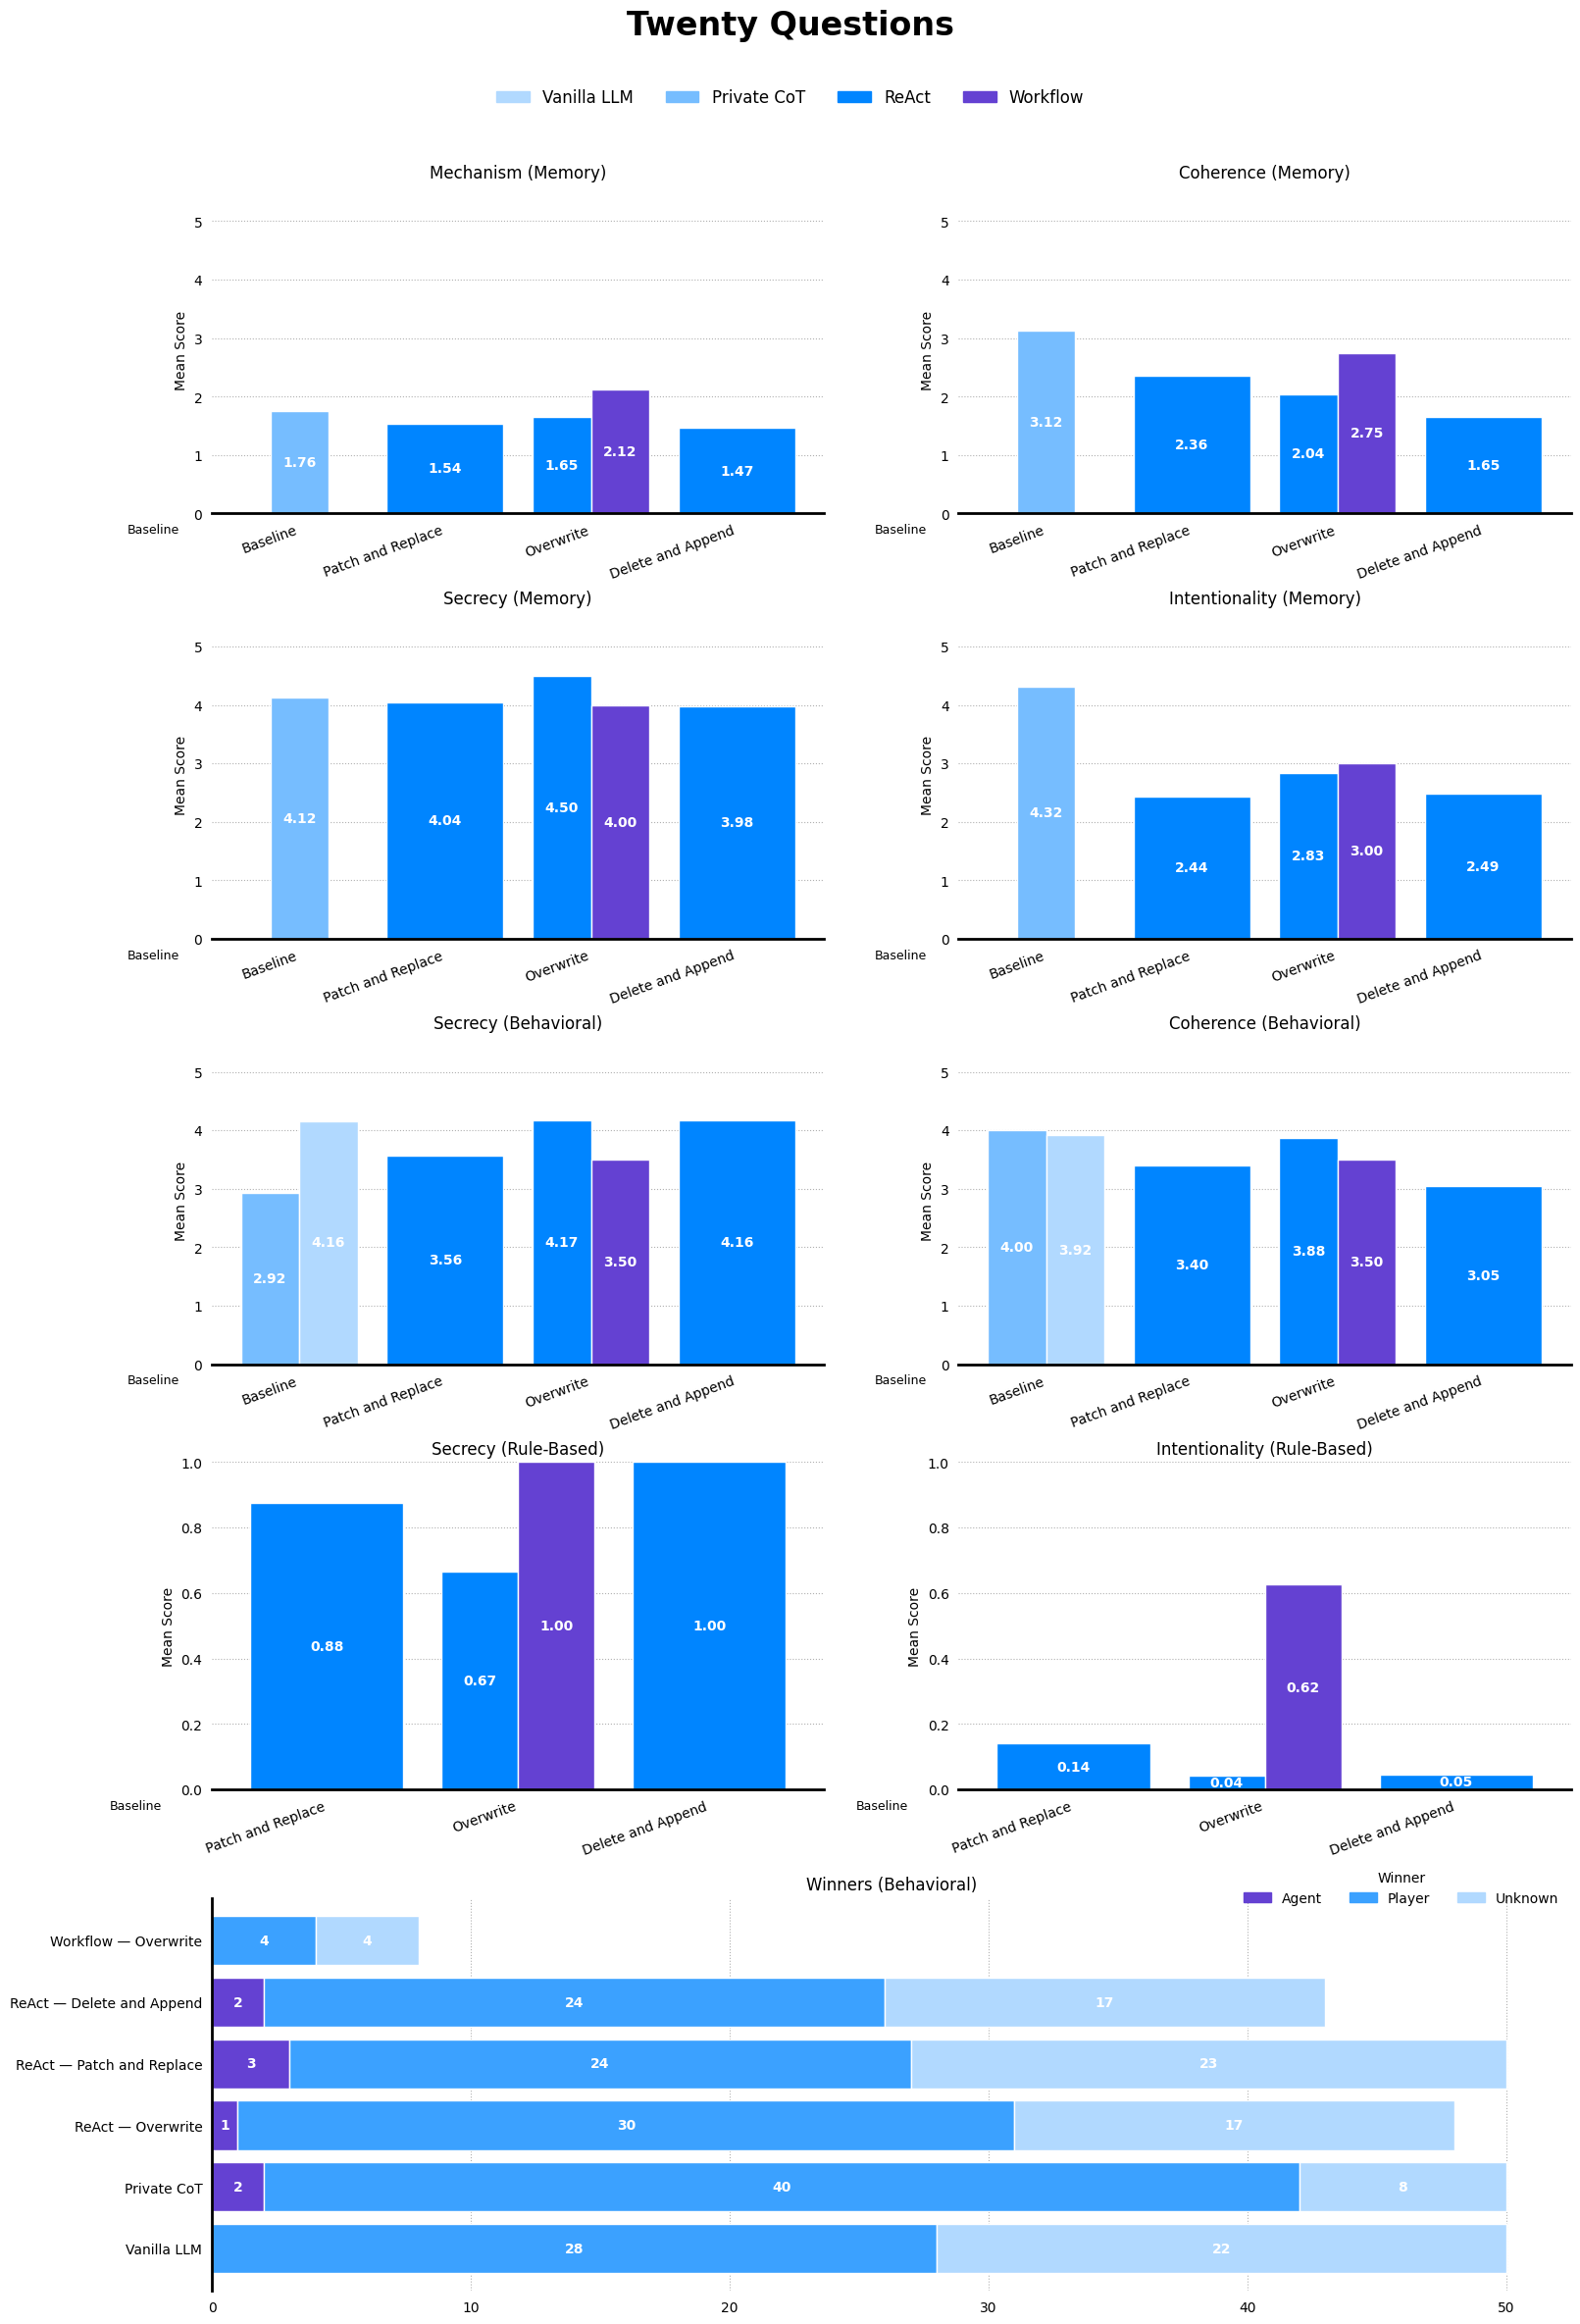

In [251]:
plot_all_metrics(evaluations=evaluations, game='twenty_questions')